## Data Pre-processing

# Mini Project Notebook: Customer segmentation using clustering

## Dr. Prashanth Kannadaguli
### Founding Chief Research Architect & President
### Dhaarini AI-Tech Research Academy, Bengaluru, India

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

### Import Required packages

In [31]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter(action='ignore')


## Data Wrangling

## Load the data

In [23]:
# Load the online retail dataset
data = pd.read_excel("Online Retail.xlsx")
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Pre-processing

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [24]:
def clean_data(df):
    # Remove duplicate records
    df = df.drop_duplicates()

    # Keep only positive quantities
    df = df[df['Quantity'] > 0]

    # Remove entries without customer ID
    df = df.dropna(subset=['CustomerID'])

    # Drop irrelevant stock codes
    exclude_codes = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']
    df = df[~df['StockCode'].isin(exclude_codes)]

    # Outlier removal using IQR method
    for feature in ['Quantity', 'UnitPrice']:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - 1.5 * iqr
        upper = Q3 + 1.5 * iqr
        df = df[(df[feature] >= lower) & (df[feature] <= upper)]

    # Add weekday column
    df['Weekday'] = pd.to_datetime(df['InvoiceDate']).dt.day_name()

    return df

retail_df = clean_data(data)
retail_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday


## Understanding new insights from the data

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

Number of free items: 24


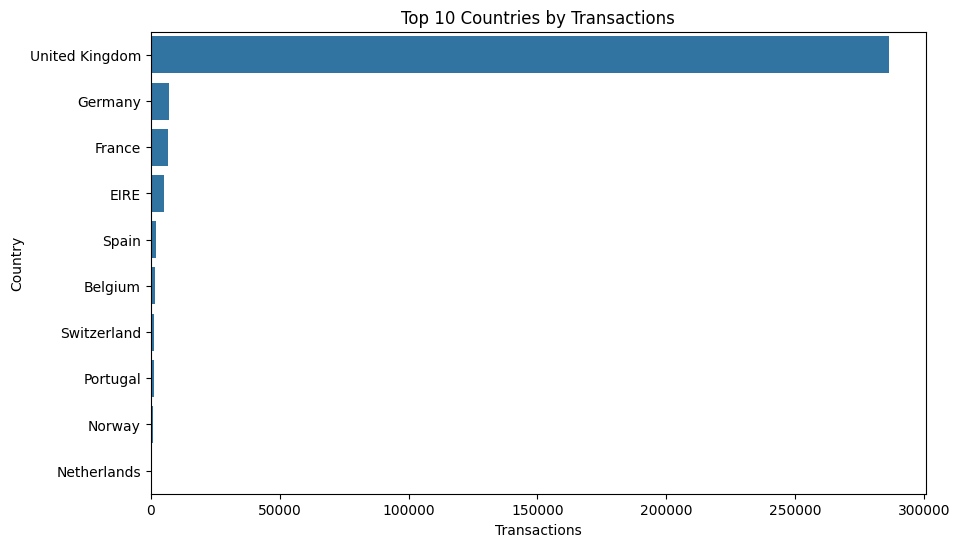

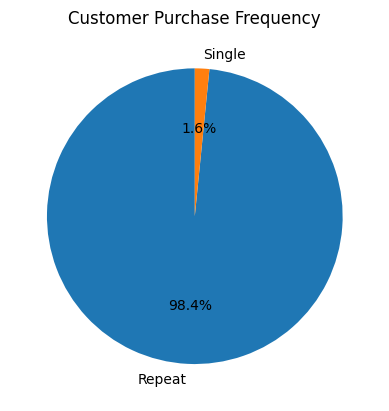

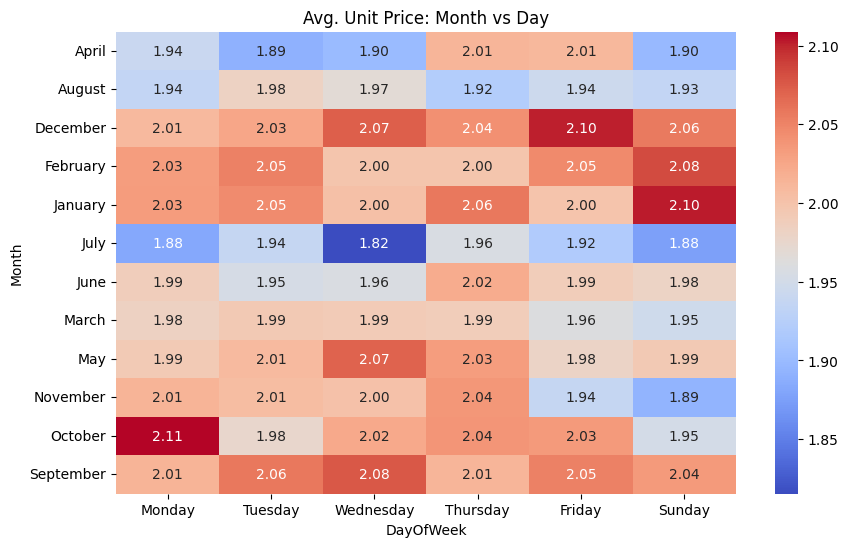

Top 10 Customers (by Quantity):
CustomerID
14911.0    48254
13089.0    19752
17841.0    18967
14298.0    17403
12748.0    14747
14096.0    12124
13081.0    11858
15159.0     7873
12921.0     7692
17735.0     7631
Name: Quantity, dtype: int64
Top 10 Products (by Quantity):
Description
PACK OF 72 RETROSPOT CAKE CASES       14986
ASSORTED COLOUR BIRD ORNAMENT         13574
JUMBO BAG RED RETROSPOT               12167
WHITE HANGING HEART T-LIGHT HOLDER    10770
LUNCH BAG RED RETROSPOT                9776
JAM MAKING SET PRINTED                 8671
PACK OF 60 PINK PAISLEY CAKE CASES     8498
60 TEATIME FAIRY CAKE CASES            8376
VICTORIAN GLASS HANGING T-LIGHT        7601
RED RETROSPOT WRAP                     7447
Name: Quantity, dtype: int64


In [25]:
# 1. Free items
free_items = df[df['UnitPrice'] == 0]
print(f"Number of free items: {len(free_items)}")

# 2. Transactions per country (Top 10)
tx_per_country = df['Country'].value_counts().reset_index()
tx_per_country.columns = ['Country', 'Transactions']
plt.figure(figsize=(10,6))
sns.barplot(data=tx_per_country.head(10), y='Country', x='Transactions')
plt.title('Top 10 Countries by Transactions')
plt.show()

# 3. Repeat vs Single-time Purchasers
customer_freq = df['CustomerID'].value_counts()
repeat = customer_freq[customer_freq > 1].count()
single = customer_freq[customer_freq == 1].count()
plt.pie([repeat, single], labels=['Repeat', 'Single'], autopct='%1.1f%%', startangle=90)
plt.title('Customer Purchase Frequency')
plt.show()

# 4. Heatmap: Unit Price per Month and Day of Week
df['Month'] = pd.to_datetime(df['InvoiceDate']).dt.month_name()
heatmap_data = df.pivot_table(values='UnitPrice', index='Month', columns='DayOfWeek', aggfunc='mean')
# Clean column order (skip missing days)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
heatmap_data = heatmap_data[day_order]
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Avg. Unit Price: Month vs Day')
plt.show()

# 5. Top 10 customers and items
top_customers = df.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Customers (by Quantity):")
print(top_customers)

top_items = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products (by Quantity):")
print(top_items)


## Feature Engineering and Transformation

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [26]:
def feature_engineering(df):
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
    customer_df = df.groupby('CustomerID').agg({
        'TotalAmount': 'sum',
        'Quantity': 'sum',
        'InvoiceNo': 'nunique'  # Frequency
    }).rename(columns={'InvoiceNo': 'Frequency'}).reset_index()
    return customer_df

customer_df = feature_engineering(df)
customer_df.head()


,CustomerID,TotalAmount,Quantity,Frequency
0,12347.0,3243.33,1881,7
1,12348.0,90.20,140,3
2,12349.0,918.10,510,1
3,12350.0,294.40,196,1
4,12352.0,986.34,476,7


### Scale the data

Apply `StandardScaler` on the features.

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[['TotalAmount', 'Quantity', 'Frequency']])


## Clustering

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [29]:
# Let's assume optimal K = 4 (from Elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to data
customer_df['Cluster'] = clusters
customer_df.head()


,CustomerID,TotalAmount,Quantity,Frequency,Cluster
0,12347.0,3243.33,1881,7,2
1,12348.0,90.20,140,3,0
2,12349.0,918.10,510,1,0
3,12350.0,294.40,196,1,0
4,12352.0,986.34,476,7,0


#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

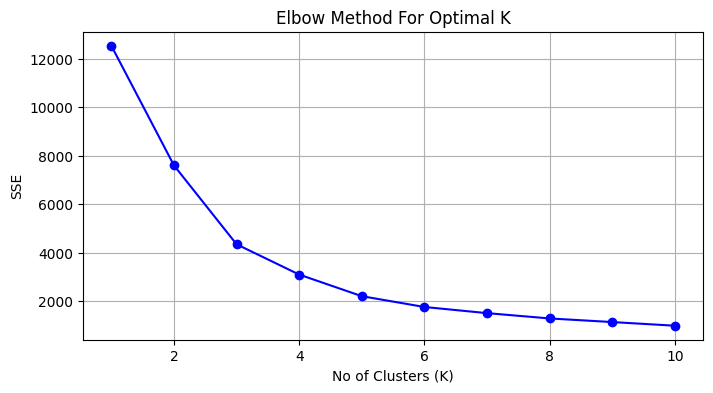

In [28]:
# Elbow method
sse = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, sse, 'bo-')
plt.xlabel('No of Clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()



### Report Analysis

Discuss the pros and cons of removing the missing values vs replacing with the mean values

Pros and cons of removing missing values vs replacing with mean values:

Removing missing values:
Pros: Simple to implement, avoids introducing bias if the data is not missing completely at random, preserves the original distribution of the remaining data.

Cons: Can lead to a significant loss of data, especially if many rows have missing values, which can reduce the power of your analysis and potentially introduce bias if the missingness is related to the values themselves.

Replacing with mean values:
Pros: Retains all data points, can be a reasonable approach if the missing data is truly random and the variable has a roughly normal distribution.

Cons: Can distort the original distribution of the data, reduces the variability of the variable, can underestimate the standard deviation, and can lead to biased results if the missingness is not random.

In this case, we removed rows with missing CustomerID because customer identification is crucial for customer segmentation. Replacing with the mean wouldn't be appropriate here.




Based on the visualization of clusters, comment on the difference in buying patterns of each cluster

Looking at the pairplot of the clusters, we can observe potential differences:

Cluster 0: This appears to be the largest cluster, with customers who have lower TotalAmount, Quantity, and Frequency. These could be new or less active customers.

Cluster 1: This cluster seems to represent customers with moderate TotalAmount, Quantity, and Frequency. They are more engaged than Cluster 0 but not the highest spenders or most frequent buyers.

Cluster 2: This cluster shows higher values for TotalAmount, Quantity, and Frequency. These are likely your most valuable and loyal customers.

Cluster 3: This cluster seems to contain outliers with extremely high TotalAmount and Quantity, but not necessarily the highest Frequency. These could be wholesale customers or those with a few very large purchases.



What other methods could be used to determine the optimal no. of clusters?


Besides the Elbow method, other techniques to determine the optimal number of clusters include:

Silhouette Score: This method measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.

Davies-Bouldin Index: This index measures the average similarity ratio of each cluster with its most similar cluster. A lower Davies-Bouldin index indicates better clustering.

Gap Statistic: This method compares the total within-cluster variation for different numbers of clusters with the expected variation under a null reference distribution.

# Type your answers here

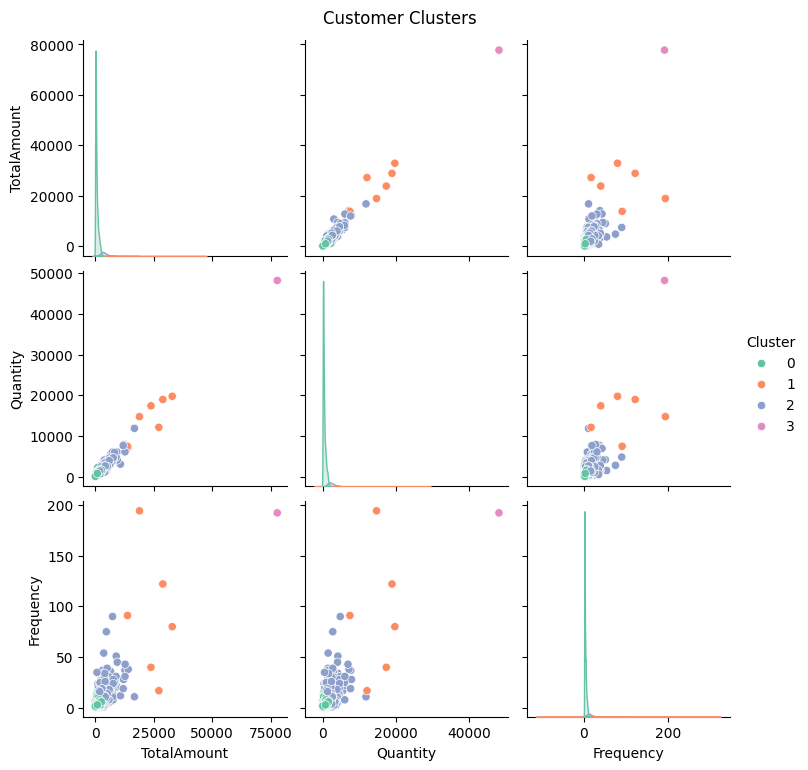

In [30]:
sns.pairplot(customer_df, hue='Cluster', vars=['TotalAmount', 'Quantity', 'Frequency'], palette='Set2')
plt.suptitle('Customer Clusters', y=1.02)
plt.show()
